In [1]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

import mpld3
#sys.path.append("Z:\\Code\\PythonCode\\")
#import niceplot

C:\Users\Student\Anaconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
dts = ddm.genLogDist(1,2998,400)

In [3]:
Fit_Results = {} #initialize once, you can keep all of the data in this pickle file and use it later

In [4]:
#load in the allResults file from the ddm anlaysis (the name of the videos)
Sample = ['AllResultsActin4fps713_1','AllResultsActin9.5fps713_2','AllResultsActin40fps717_3'] 

In [60]:
#Set the frame rate and the dimensions
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 9.5
px = 0.196
imDimension = 128
q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*px))
times = dts/framerate

In [61]:
# This is the number of videos for each sample 
samNumber = ['1', '3','4']#,'5','6','7','8']

In [62]:
# These are the ROIs used and saved in your pickle file
ROI = ['0','128','256','384','512','640']

In [63]:
# initialize this matrix: you will put all taus into this matrix from each video, 
# so make sure that you have more than enough rows to do so
tau_b = np.zeros([100,63])

In [64]:
# this sets which sample and which video is being read into the code
num = 1 #the sample
ss = 0 #the video for the sample

In [67]:
#Load in the allResults file
#change the file and directory as needed
data_dir = "Z:\\ChristelleSummer2018\\Data\\BeadsInConditions\\Actin\\2018_07_13\\9.5\\2018_07_13_Actin9.5fps_2\\"
data_file ='AllResultsActin9.5fps713_2.p'
Ana_data = pickle.load(open(data_dir + data_file, 'r'))

In [68]:
Ana_data

{'chi20': array([0.00000000e+00, 2.64931393e+16, 2.47095795e+16, 1.74573327e+16,
        2.49096080e+07, 1.00338980e+07, 6.69065162e+06, 3.65872997e+06,
        2.33188603e+06, 1.29160527e+06, 9.37880544e+05, 9.28141283e+05,
        5.82580303e+05, 3.78425891e+05, 5.25592863e+05, 3.14424285e+11,
        5.77033357e+11, 1.58658309e+10, 2.77319510e+05, 1.89766732e+05,
        1.68310550e+05, 1.44730456e+05, 1.78354964e+05, 1.63029251e+05,
        1.70177817e+05, 1.46018168e+05, 1.32055539e+05, 1.20591862e+05,
        1.56241023e+05, 1.27425504e+05, 1.35753218e+05, 1.33673366e+05,
        1.50414520e+05, 1.45603450e+05, 9.91951993e+04, 9.06160500e+04,
        7.28383517e+04, 8.32499515e+04, 8.64652825e+04, 8.59343321e+04,
        1.06293286e+05, 9.99261444e+04, 9.27040264e+04, 8.56202642e+04,
        7.71021866e+04, 9.48697506e+04, 8.06772969e+04, 8.41048541e+04,
        1.08944566e+05, 8.33800810e+04, 6.95308019e+04, 8.43222433e+04,
        7.18567130e+04, 7.37921299e+04, 6.36257264e+04,

In [71]:
#This will plot all of the q vs tau for all of the ROIs in the   
tau = np.zeros([len(ROI),63]) #decay time: change the 63 10 127 if you are using 256 instead of 128
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)

for i in range(len(ROI)):
    fitparams = Ana_data['fitparams'+ROI[i]]
    tau[i,:] = fitparams[:,1]
    amp[i,:] = fitparams[:,0]
    bg[i,:] = fitparams[:,2]
    alph[i,:] = fitparams[:,3]
    print i

4
5


In [75]:
#Use the DiffCoef after Devynn has fixed it... 
#Fit each ROI and record the diffusion coefficient and alpha value (in an excel)
# write down the diffusion coefficient, alpha value, and the q range used
chg=1
def DiffCoef (newtau_average, qrange, qmin, qmax):
    nt = newtau_average
    indx = np.where((q>=qmin)&(q<=qmax))
    print indx
    ds = (qrange[indx[0]]**-2.0) / nt[indx[0]]
    return ds.mean(), indx

def plot_results( qmin = q[2], qmax = q[10]):
    taus = ddm.newt(tau[chg,:], alph[chg,:])
    b = np.where((q>=qmin)&(q<=qmax))
    a = np.polyfit( np.log(q[b[0]]),np.log(taus[b[0]]), 1)
    slope = a[0]
    coef1 = np.exp(a[1])
    Dif = (1/coef1)
    alpha = 2./(-1*slope)
    print(b[0])
    ifDiff = DiffCoef(taus,q,qmin,qmax)
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(q[1:-2], taus[1:-1], 'ro')
    ax.loglog(q[1:-2], coef1*(q[1:-2])**slope, '-k')
    ax.plot(q[1:-2], (1./ifDiff[0]) * 1./(q[1:-2]**2.0), '--k')
    ax.loglog(q[b[0]],taus[b[0]],'b.')
    ax.text(0.55,0.8,'D = %.4f' %Dif, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.66,'alpha = %.4f' %alpha, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)

C:\Users\Student\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app
C:\Users\Student\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power


[ 4  5  6  7  8  9 10 11]
(array([ 4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),)


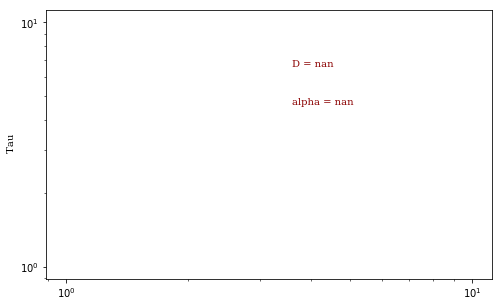

In [73]:
plot_results(q[4],q[11])

In [74]:
#This plots the function above and should spit out the important info 
#Change the chg to change the ROI you are fitting
%matplotlib inline
mpld3.enable_notebook()
interact(plot_results, qmin = (q[1],q[5]), qmax = (q[4],q[30]), continuous_update=False)
# keep track of the ROIs that are bad, you will do this in the excel sheet 
#because you will want to plot each video separately and it can be confusing

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuNTAwODkxNjg1ODQwMjA5NCwgZGVzY3JpcHRpb249dSdxbWluJywgbWF4PTEuMjUyMjI5MjE0NjAwNTIzNCwgbWluPTDigKY=


<function __main__.plot_results>

In [57]:
# video save tau into tau_b
tau_b[chg,:] = ddm.newt(tau[chg],alph[chg]) #make sure to change the range that you put into the matrix or 
                            #you will overwrite your data and that will suck
                        # only save the taus that look ok

In [58]:
#Use this to check what components of tau_b have data in it
tau_b[chg]

array([          nan,  542.88813427, 3274.37325685, 3274.37325685,
       3274.37325685, 3274.37325685, 3274.37325685, 3274.37325685,
       3274.37325685,  438.65946243,  143.22059736,  103.75108641,
         95.5389035 ,  104.02595847,   68.6152301 ,   36.82354118,
         35.27036403,   48.63403663,   25.03805509,   12.27504195,
          3.89564599,    3.30939884,    9.25511788, 3274.37325685,
       3274.37325685, 3274.37325685, 3274.37325685, 3274.37325685,
       3274.37325685, 3274.37325685, 3274.37325685, 3274.37325685,
       3274.37325685, 3274.37325685, 3274.37325685, 3274.37325685,
       3274.37325685, 3274.37325685, 1021.65620456, 3274.24519497,
       3274.37325685, 3274.37325685, 3274.37325685, 3274.36998881,
       3274.37325685, 3274.37325685,  322.7221041 , 3274.37325685,
       3274.37325685, 2773.68773614, 3274.37325685, 3274.37325685,
       3274.37325685, 3274.37325685, 3274.37325685, 2168.8155788 ,
       2878.7354074 , 3274.37325685, 3274.37325685, 3274.37325

In [59]:
Fit_Results['allTaus_'+Sample[num]] = tau_b #save this once you have finished all of the videos for the sample

In [ ]:
#Once finished with the video, start over and do for the next (change ss)
#Once finished with the sample, fully start over changing num to 0 and ss to 0
#Reinitialize tau_b

In [ ]:
# After finishing the initial analysis and fitting you will want to plot tau v q for each video, 
# for all of the videos for the sample, and all of the samples together



In [538]:
Round2_Results['allTaus_MT'] = tauB

In [614]:
pickle.dump(Round2_Results, open("E:\\AllData_Results\\AllResults_better.p", 'wb'))

NameError: name 'ROI' is not defined

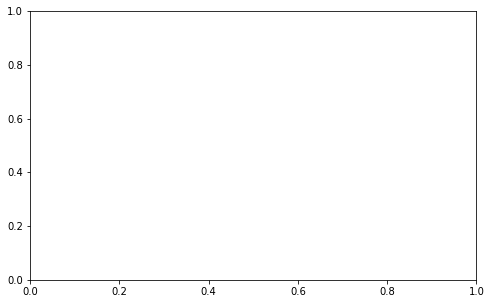

In [13]:
%matplotlib inline
mpld3.enable_notebook()

col = ['ro','bo','go','co','ko','mo','yo','rv','bv']
fig,ax = plt.subplots(figsize=(8,8/1.618))
for i in range(len(ROI)):
    ax.loglog(q[2:-2], tau[i,2:-1], col[i])
    

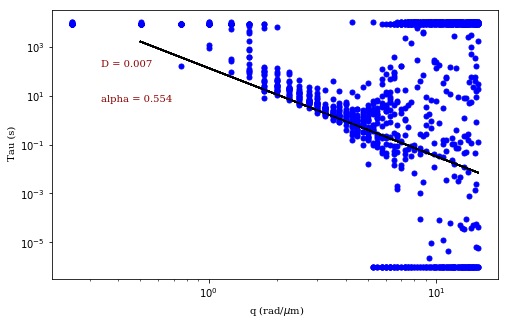

In [59]:

col = ['ro','bo','go','co','ko','mo','yo','rv','bv']
tau = Round2_Results['allTaus_Co']
tau2 = Round2_Results['allTaus_Actin256_2']
'''
fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v1):
    ax.loglog(q[1:-2], tau[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./.0067) * 1./(q[2:-2]**(2/.59)), '-k')
ax.text(0.11,0.8,'D = %.3f' %.0067, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.59, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_vid1_1.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v1b):
    ax.loglog(q[1:-2], tau2[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./.0078) * 1./(q[2:-2]**(2/.598)), '-k')
ax.text(0.11,0.8,'D = %.3f' %.0078, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.598, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_vid1_2.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v2):
    ax.loglog(q[1:-2], tau[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./0.008) * 1./(q[2:-2]**(2/.596)), '-k')
ax.text(0.11,0.8,'D = %.3f' %0.008, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.596, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_vid2_1.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v2b):
    ax.loglog(q[1:-2], tau2[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./0.0095) * 1./(q[2:-2]**(2/.602)), '-k')
ax.text(0.11,0.8,'D = %.3f' %0.0095, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.602, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\MT_vid2_2.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v3):
    ax.loglog(q[1:-2], tau[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./0.0065) * 1./(q[2:-2]**(2/.596)), '-k')
ax.text(0.11,0.8,'D = %.3f' %0.0065, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.596, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_vid3_1.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v5b):
    ax.loglog(q[1:-2], tau2[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./0.00625) * 1./(q[2:-2]**(2/.563)), '-k')
ax.text(0.11,0.8,'D = %.3f' %0.00625, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.563, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_vid5_2.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v5):
    ax.loglog(q[1:-2], tau[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./0.00617) * 1./(q[2:-2]**(2/.666)), '-k')
ax.text(0.11,0.8,'D = %.3f' %0.00617, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.666, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_vid5_1.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(v6):
    ax.loglog(q[1:-2], tau[j,1:-1],  col[i], markersize = 7)
    ax.plot(q[2:-2], (1./0.0085) * 1./(q[2:-2]**(2/.584)), '-k')
ax.text(0.11,0.8,'D = %.3f' %0.0085, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.584, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_vid6_1.svg")

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(al):
    ax.loglog(q[1:-2], tau[j,1:-1],  'bo', markersize = 5)
    #ax.plot(q[2:-2], (1./0.0793) * 1./(q[2:-2]**(2/0.658)), '-k')
ax.text(0.33,0.8,'D = %.3f' %0.0793, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.33,0.67,'alpha = %.3f' %0.658, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Act_All_1.svg")
'''
fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(al):
    ax.loglog(q[1:-2], tau[j,1:-1],  'bo', markersize = 5)
    ax.plot(q[2:-2], (1./0.0074) * 1./(q[2:-2]**(2/0.554)), '-k')
ax.text(0.11,0.8,'D = %.3f' %0.0074, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.text(0.11,0.67,'alpha = %.3f' %0.554, 
    fontdict=font_plt,horizontalalignment='left', 
    verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\Co_All.png")


In [22]:
tauB = Round2_Results['allTaus_Buffer']
tauM = Round2_Results['allTaus_MT']
tauC = Round2_Results['allTaus_Co']
tau2 = Round2_Results['allTaus_Actin256_2']

fig,ax = plt.subplots(figsize=(8,8/1.618))
for i,j in enumerate(alC):
    ax.loglog(q[1:-2], tauC[j,1:-1],  'bo', markersize = 3)
    ax.plot(q[2:-2], (1./0.0074) * 1./(q[2:-2]**(2/0.554)), '-k')
for i,j in enumerate(alB):
    ax.loglog(q[1:-2], tauB[j,1:-1],  'ro', markersize = 3)
    ax.plot(q[2:-2], (1./0.373) * 1./(q[2:-2]**(2/.974)), '-k')
for i,j in enumerate(alM):
    ax.loglog(q[1:-2], tauM[j,1:-1],  'go', markersize = 3)
    ax.plot(q[2:-2], (1./0.0793) * 1./(q[2:-2]**(2/0.658)), '-k')
for i,j in enumerate(al2):
    ax.loglog(q2[1:-2], tau2[j,1:-1],  'mo', markersize = 3)
    ax.plot(q2[2:-2], (1./0.0079) * 1./(q2[2:-2]**(2/0.59)), '-k')
ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
plt.savefig("E:\\AllData_Results\\All_All.png")

NameError: name 'Round2_Results' is not defined

In [40]:
len(al)


29

In [100]:
tauA[23]

array([2.03574700e+04, 2.03310276e+04, 2.03398186e+04, 1.00272396e+02,
       2.03313470e+04, 2.03200796e+04, 2.03277248e+04, 4.76880848e+03,
       3.68163540e+02, 6.83922191e+02, 2.03140441e+04, 3.32536842e+02,
       3.81638024e+02, 1.37179069e+02, 1.37216469e+02, 5.22628038e+01,
       3.90828221e+01, 2.30918837e+01, 4.01174491e+01, 1.79049083e+01,
       1.52342736e+01, 1.03477532e+01, 1.00680211e+01, 6.87756369e+00,
       7.31352281e+00, 5.61374452e+00, 6.97850748e+00, 4.62369667e+00,
       5.77958906e+00, 3.24106962e+00, 5.75114011e+00, 3.40833246e+00,
       4.79059146e+00, 2.95210741e+00, 2.58745927e+00, 2.47942210e+00,
       1.86527449e+00, 6.78942998e+00, 4.07327518e+00, 1.61230118e+00,
       1.44404388e+01, 6.21163868e+00, 3.67700388e+00, 5.05829419e+00,
       6.88510777e-01, 5.31148602e+02, 1.71183949e+01, 2.28744532e+04,
       2.28744532e+04, 2.18725276e-01, 2.28744532e+04, 4.58673848e+01,
       2.22736679e-01, 1.41387652e-01, 5.95668740e-01, 1.31470797e-01,
      

In [92]:
this = 21
that = this+len(ROI)

tauA[this:that,:] = tauB

In [102]:
taus = np.mean(tauA[:23,:], axis=0)
taustd = np.std(tauA[:23,:], axis=0)

In [117]:
taus[2:-27].shape

(95L,)

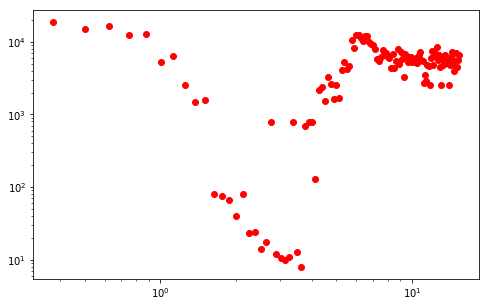

In [119]:
fig,ax = plt.subplots(figsize=(8,8/1.618))
ax.loglog(q[3:-4], taus[2:-1], 'ro')
#ax.errorbar(q[3:-30],taus[2:-27],yerr=taustd[2:-27],fmt='ro', elinewidth = 1.3, capsize=2)

In [120]:
Round2_Results['Actin_256_average_newtau'] = taus
Round2_Results['Actin_256_std_newtau'] = taustd

In [121]:
pickle.dump(Round2_Results, open('E:\\AllData_Results\\Actin_256x256.p','wb'))

In [126]:
#Ana_data.keys()

In [541]:
#pickle.dump(Round2_Results, open('E:\\AllData_Results\\AllConditions_results.p','wb'))

In [125]:
#Round2_Results.keys()

ValueError: x and y must have same first dimension, but have shapes (60L,) and (124L,)

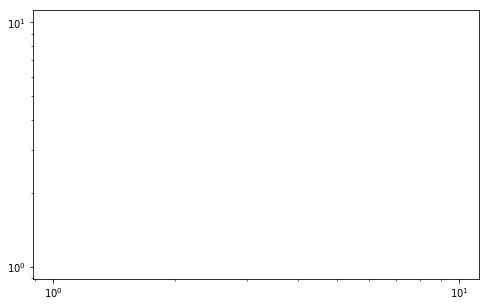

In [127]:
%matplotlib inline
mpld3.enable_notebook()

a = ['Dilute','MT','Actin','Copoly']
cc = ['ro', 'bo','go','mo']
diffusionCo = [0.309,0.039,0.0037,0.0031]


fig,ax = plt.subplots(figsize=(8,8/1.618))
for i in range(4):
    taus = Ana_data[a[i]+'_average_newtau']
    ax.loglog(taus,(2*np.pi)/q[3:-1],  cc[i])
ax.set_ylim(1.0,11)
#plt.savefig('E:\\AllData_Results\\AllConditions.svg')

    #ax.plot((1./diffusionCo[i]) * 1./(q[5:-42]**slope[i]), (2*np.pi)/q[5:-42],  '-k')


for i in range(4):
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    taus = Ana_data[a[i]+'_average_newtau']
    ax.loglog(taus,(2*np.pi)/q[3:-1],  cc[i])
    ax.plot((1./0.1) * 1./(q[2:-42]**2.0), (2*np.pi)/q[2:-42],  '-k')
    ax.set_ylim(1.0,11)
    #plt.savefig('E:\\AllData_Results\\'+a[i]+'Condition.svg')
    
    #ax.errorbar(q[3:-30],taus[:-29],yerr=taustd[:-29],fmt=cc[i], elinewidth = 1.3, capsize=2)

In [335]:
DC_roi[chg] = 0.24
a_roi[chg] = 2/2.4

In [314]:
Round2_Results['Diffusion1'+Sample2[num]+'_'+samNumber[0]] = DC_roi
Round2_Results['Diffusion2'+Sample2[num]+'_'+samNumber[1]] = DC_roi2
Round2_Results['alpha1'+Sample2[num]+'_'+samNumber[0]] = a_roi
Round2_Results['alpha2'+Sample2[num]+'_'+samNumber[1]] = a_roi2

In [273]:
Round2_Results['newTaus_ROIs'+Sample2[num]+'_'+samNumber[ss]] = ntav
Round2_Results['newTausSTD_ROIs'+Sample2[num]+'_'+samNumber[ss]] = ntstd

In [180]:
pickle.dump(Round2_Results, open('Z:\\Devynn_Summer2018\\Data\\AllData_Results\\Round2_Results_BufferConditions_withoutDiffCoeffs_all.p','wb'))

In [421]:
ntav.shape

(31L,)

In [217]:
R1 = np.zeros([len(ROI),2])
R2 = np.zeros([len(ROI),2])

(0.9, 15)

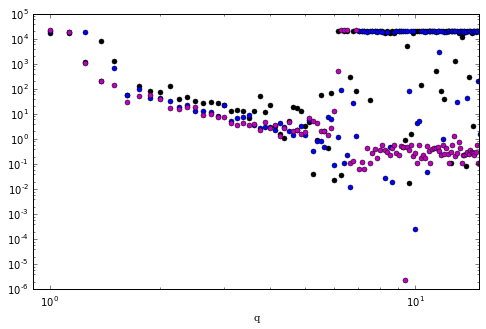

In [36]:
%matplotlib inline
mpld3.enable_notebook()
V = ['top', 'bottom']
z = 0

ROI = ['0', '256', '512']
#This will plot all of the q vs tau for all of the ROIs in the   
tau = np.zeros([len(ROI),127]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)
#fitparams = np.zeros([63,7])
for i in range(len(ROI)):
    fitparams = Ana_data['fitparams_'+ROI[i]]
    tau[i,:] = fitparams[:,1]
    amp[i,:] = fitparams[:,0]
    bg[i,:] = fitparams[:,2]
    alph[i,:] = fitparams[:,3]

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.set_xlabel("q", fontdict=font_plt_ax)

nt = np.zeros([len(ROI),31])
cols = ['ko','bo','mo','go','co','yo','ro','gv','bv','mv']
for i in range(len(ROI)):
    ax.loglog(q[3:-1], ddm.newt(tau[i,2:-1], alph[i,2:-1]), cols[i], ms= 5.0)

ntav = np.mean(nt, axis=0)
ntstd = np.std(nt,axis=0)

#ax.loglog(q[3:-30], ntav, 'rv')
ax.set_xlim(0.9,15)

In [177]:
Round2_Results.keys()

['newTaus_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_2',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_2',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_2',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_2',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_2',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_1',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_2',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_1',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_1',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_2',
 'newTausSTD_

In [518]:
#ToKeep.keys()

After averaging each of the ROIs: average together the videos and get a diffusion coefficient for each video and then for the average

In [182]:
Condition = pickle.load(open('Z:\\Devynn_Summer2018\\Data\\AllData_Results\\Round2_Results_BufferConditions_withoutDiffCoeffs_all.p','rb'))
Smps = ['allResults_0.02mgmlDNA_CoNetwork_29fps_34exp','allResults_0.02mgmlDNA_MTNetwork_29fps_34exp','allResults_0.02mgmlDNA_ActinNetwork_29fps_34exp']

In [183]:
SS =['allResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_1','allResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_2', 
     'allResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_1','allResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_2',
     'allResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_1','allResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_2',
     'allResults_0.02mgmlDNA_Buffer_99fps_10exp_1','allResults_0.02mgmlDNA_Buffer_99fps_10exp_2']

In [317]:
DC_roi = np.zeros(len(ROI))
a_roi = np.zeros(len(ROI))
DC_roi2 = np.zeros(len(ROI))
a_roi2 = np.zeros(len(ROI))

In [185]:
#Condition.keys()

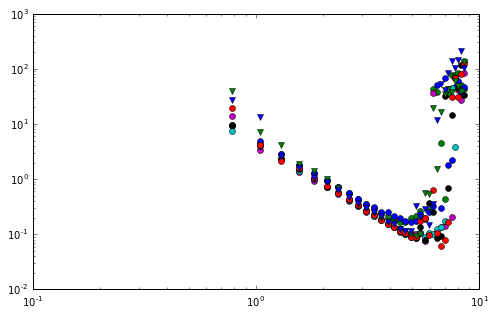

In [187]:
%matplotlib inline
mpld3.enable_notebook()

samNumber = ['1', '2']
ROI = ['0', '128', '256', '384','512', '640','768','896']
#['1_top','1_bottom','2_top','2_bottom','4_top','6_top','6_bottom','7_top','8_top','8_bottom']
theone = 0
tau = np.zeros([len(SS),31])
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca();
col = ['go', 'bo', 'mo', 'co','ko', 'ro','gv','bv','mv','cv','kv','rv']
for i in range(len(SS)):
    tau[i] = Condition['newTaus_ROIs'+SS[i]]
    std = Condition['newTausSTD_ROIs'+SS[i]]
    ax.loglog(q[3:-30],tau[i], col[i])
tauAVG = np.mean(tau,axis=0)
tauSTD = np.std(tau,axis=0)

In [188]:
DC = np.zeros(len(SS))
Sa = np.zeros(len(SS))

In [87]:
b = np.where((q>=0.7)&(q<=1.7))
b

(array([3, 4, 5, 6], dtype=int64),)

[-1.93379391  1.26621001]


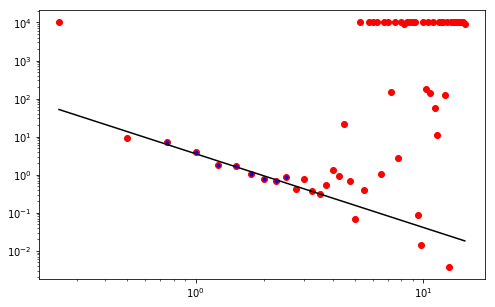

In [104]:
b = np.where((q>=0.6)&(q<=2.7))
a = np.polyfit( np.log(q[b[0]]),np.log(tauB[0,b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])

print(a)
fig,ax = plt.subplots(figsize=(8,8/1.618))
ax.loglog(q[1:-2],tauB[0,1:-1],'ro')
ax.loglog(q[1:-2], coef1*(q[1:-2])**slope, '-k')
ax.loglog(q[b[0]],tauB[0,b[0]],'b.')

In [ ]:
fits = Diff_Fit(q[2:30],tauB[2:30],q[3],q[10],alph[2:30])

In [89]:
def DiffCoef (newtau_average, qrange, qmin, qmax):
    nt = newtau_average
    indx = (qrange>qmin) & (qrange<qmax)
    ds = (qrange[indx]**-2) / nt[indx]
    return ds.mean(), indx

def Diff_Fit(qrange, taurange, qmin, qmax, StExp, slope):
    step1 = DiffCoef(taurange, StExp, qrange, qmin, qmax)
    fit1 = (1./step1[0]) * 1./(step1[1]**slope)
    return fit1, step1[0], step1[1]

#Need to fix the function so the it will fit the data

#define a function to plot the results

def plot_results(qmin = q[2], qmax = q[10], slope = 2.0):
    qs = q[3:-30]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(qs, tauB, 'ro')
    #ax.errorbar(np.log(qs),np.log(tauAVG), yerr = tauSTD, xerr = None, fmt = 'ro')
    fits = Diff_Fit(qs, tauB, qmin, qmax, alph[2:-30], slope)
    ax.loglog(qs,fits[0],'-k')
    #ax.plot(np.log(qs), np.log(fits[0]),  '-k')
    #ax.set_ylim(-2.0,10)
    ax.text(0.55,0.8,'D = %.3f' %fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.77,'slope = %.2f' %slope, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)

def roughEstimate (diffusionCo = 0.3, slope = 2.0):
    tauB
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(q[3:-30], tau[0], 'ro')
    ax.plot(q[3:-42], (1./diffusionCo) * 1./(q[3:-42]**slope), '-k')
    ax.text(0.55,0.8,'D = %.4f' %diffusionCo, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.77,'slope = %.2f' %slope, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)



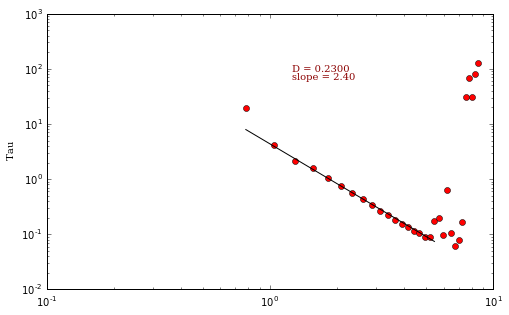

In [213]:
chg = 5
interact(roughEstimate, diffusionCo = (0.05,0.5,0.005), slope = (2.0,4.5,0.05), continuous_update=False)

In [214]:
DC[chg] = 0.3
Sa[chg] = 2/2.25 #this is alpha = 2/slope

In [215]:
AlSTD = np.std(Sa, axis=0)
DCstd = np.std(DC,axis=0)
Alavg = np.mean(Sa, axis=0)
DCavg = np.mean(DC,axis=0)
DCavg, DCstd, Alavg, AlSTD   

(0.25918749999999996,
 0.056354867524908626,
 0.87932983862678593,
 0.049956304206211076)

In [212]:
Sa

array([ 0.88888889,  0.85106383,  0.86956522,  0.86956522,  0.83333333,
        0.        ,  1.        ,  0.83333333])

In [101]:
ToKeep['DiffCoef_fromAVG_'+Smps[theone]] = DCavg
ToKeep['DiffCoefSTD_'+Smps[theone]] = DCstd
ToKeep['Alpha_fromAVG_'+Smps[theone]] = Alavg
ToKeep['AlphaSTD_'+Smps[theone]] = AlSTD
ToKeep['TauAverage_'+Smps[theone]] = tauAVG
ToKeep['TauSTD_'+Smps[theone]] = tauSTD

NameError: global name 'alph' is not defined

<function __main__.plot_results>

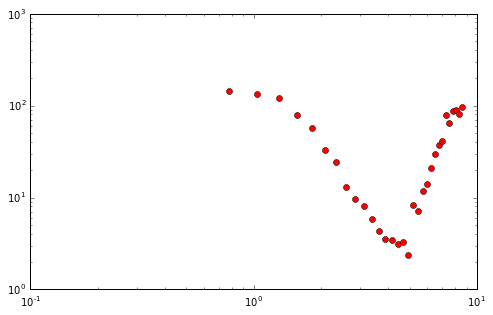

In [36]:
#fit to the high q region
interact(plot_results, qmin = (q[0], q[10]), qmax = (q[5], q[20]), slope = (2.0,4.5,0.05), continuous_update=False)

In [534]:
pickle.dump(ToKeep, open('Z:\\Devynn_Summer2018\\Data\\AllData_Results\\ToKeep_maybeallbad.p', 'wb'))

In [527]:
DiffCoef_average1 = 0.016
DiffCoef_averageAlpha1 = 2/2.00

In [495]:
def plot_resultsall(qmin = q[2], qmax = q[10], slope = 2.0):
    qs = q[3:-30]
    tau = Condition['newTaus_ROIs'+Smps[theone]+'_'+samNumber[chg]]
    std = Condition['newTausSTD_ROIs'+Smps[theone]+'_'+samNumber[chg]]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.errorbar(np.log(qs),np.log(tau), yerr = std, xerr = None, fmt = 'ro')
    fits = Diff_Fit(qs, tau, qmin, qmax, alph[2:-30], slope)
    ax.plot(np.log(qs), np.log(fits[0]),  '-k')
    ax.set_ylim(-2.0,10)
    ax.text(0.55,0.8,'D = %.3f' %fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.77,'slope = %.2f' %slope, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)
    ax.set_xlabel(" q", fontdict=font_plt_ax)
    ax.set_title(Smps[theone]+'_'+samNumber[chg], fontdict=font_plt_ax)

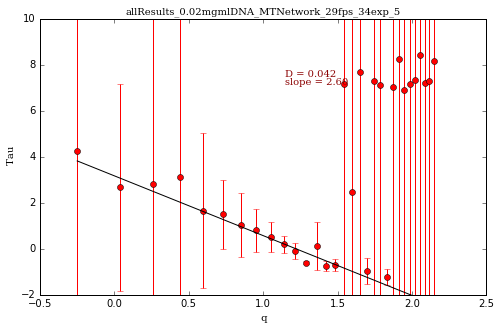

In [505]:
#fit for each video used in the average to get a standard deviation
chg = 4
interact(plot_resultsall, qmin = (q[0], q[10]), qmax = (q[5], q[20]), slope = (2.0,4.5,0.05), continuous_update=False)